# Phase 3: CPU Latency Benchmarking & ONNX Optimization

In this notebook, we evaluate the real-world performance of our models for production deployment. 
High accuracy is important, but for a real-time e-commerce API, **latency** (the time it takes to make a single prediction) is often the deciding factor.

### 🎯 Objectives:
1. **Load all 5 models** (Baseline + Tree-based + Deep Learning).
2. **Measure Single-Sample Latency**: Simulate a single API request and calculate P50, P95, and P99 statistics.
3. **Optimize TabM**: Export the PyTorch model to **ONNX** and measure the speedup.
4. **Efficiency Frontier**: Plot Accuracy vs. Latency to find the best production candidate.

In [1]:
import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import onnxruntime as ort
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Premium Styling
plt.style.use('seaborn-v0_8-whitegrid')
PRIMARY_COLOR = '#1E4FA8'

# Paths
MODELS_PATH = "../backend/models"
REPORTS_PATH = "../reports/metrics"
DATA_PATH = "../data/raw/online_shoppers_intention.csv"

# Ensure models dir exists
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

print("✅ Benchmarking environment initialized.")

✅ Benchmarking environment initialized.


## 1. Load Data & Preprocessing Context
We need a single sample formatted correctly to test realistic inference.

In [2]:
df = pd.read_csv(DATA_PATH)
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

categorical_cols = ['Month', 'VisitorType', 'Weekend']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

def preprocess_sample(df_sample):
    sample = df_sample.copy()
    sample[numerical_cols] = scaler.transform(sample[numerical_cols])
    # Ensure float32 for ONNX compatibility
    return sample.values.astype(np.float32)

test_sample_raw = X_test.iloc[:1]
test_sample_processed = preprocess_sample(test_sample_raw)
test_tensor = torch.FloatTensor(test_sample_processed)

print(f"✅ Test sample ready. Shape: {test_sample_processed.shape}")

✅ Test sample ready. Shape: (1, 17)


## 2. Load Models
We define the TabM architecture again to load the PyTorch weights.

In [3]:
class MLPBlock(nn.Module):
    def __init__(self, in_features, hidden_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()
    def forward(self, x):
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.fc2(x)))
        return x

class TabMModel(nn.Module):
    def __init__(self, n_features, hidden_dim=128, n_ensemble=8, dropout=0.1):
        super().__init__()
        self.input_bn = nn.BatchNorm1d(n_features)
        self.ensemble_blocks = nn.ModuleList([
            MLPBlock(n_features, hidden_dim, dropout) for _ in range(n_ensemble)
        ])
        self.output_heads = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(n_ensemble)
        ])
    def forward(self, x):
        x = self.input_bn(x)
        outputs = [head(block(x)) for block, head in zip(self.ensemble_blocks, self.output_heads)]
        stacked = torch.stack(outputs, dim=0)
        return stacked.mean(dim=0).squeeze(-1)

# Load Sklearn/XGB Models
try:
    models = {
        'Logistic Regression': joblib.load(f"{MODELS_PATH}/logistic_regression.joblib"),
        'XGBoost': joblib.load(f"{MODELS_PATH}/xgboost_model.joblib"),
        'Random Forest': joblib.load(f"{MODELS_PATH}/random_forest_model.joblib"),
        'SVM': joblib.load(f"{MODELS_PATH}/svm_model.joblib")
    }
except FileNotFoundError as e:
    print(f"⚠️ Error loading baseline models: {e}")
    print("Please ensure Phase 1 notebook has been run.")
    models = {}

# Load TabM PyTorch
try:
    checkpoint = torch.load(f"{MODELS_PATH}/tabm_model.pt", map_location='cpu')
    config = checkpoint['config']
    tabm_model = TabMModel(checkpoint['n_features'], config['hidden_dim'], config['n_ensemble'], config['dropout'])
    tabm_model.load_state_dict(checkpoint['state_dict'])
    tabm_model.eval()
    print("✅ All models loaded successfully.")
except FileNotFoundError:
    print("⚠️ TabM model not found. Please run Phase 2 notebook first.")
    tabm_model = None

⚠️ Error loading baseline models: [Errno 2] No such file or directory: '../backend/models/xgboost_model.joblib'
Please ensure Phase 1 notebook has been run.
✅ All models loaded successfully.


## 3. Benchmarking Logic
We run 100 warm-up rounds and 1000 timed rounds to ensure statistical significance.

In [4]:
def benchmark_model(model_name, model_obj, input_data, iters=1000, warm_up=100):
    latencies = []
    
    # Warm-up
    for _ in range(warm_up):
        if model_name == 'TabM (PyTorch)':
            with torch.no_grad(): _ = torch.sigmoid(model_obj(input_data))
        else:
            # Some sklearn models expect 2D array
            try:
                _ = model_obj.predict_proba(input_data)
            except:
                # If predict_proba fails, try predict (e.g. some SVM configurations)
                _ = model_obj.predict(input_data)
            
    # Measurement
    for _ in range(iters):
        start = time.perf_counter()
        if model_name == 'TabM (PyTorch)':
            with torch.no_grad(): _ = torch.sigmoid(model_obj(input_data))
        else:
            try:
                _ = model_obj.predict_proba(input_data)
            except:
                _ = model_obj.predict(input_data)
        latencies.append((time.perf_counter() - start) * 1000) # to ms
        
    return {
        'mean': np.mean(latencies),
        'p50': np.percentile(latencies, 50),
        'p95': np.percentile(latencies, 95),
        'p99': np.percentile(latencies, 99)
    }

results = []

# Benchmark Baselines
for name, obj in models.items():
    print(f"Benchmarking {name}...")
    stats = benchmark_model(name, obj, test_sample_processed)
    stats['model'] = name
    results.append(stats)

# Benchmark TabM PyTorch
if tabm_model:
    print("Benchmarking TabM (PyTorch)...")
    tabm_stats = benchmark_model('TabM (PyTorch)', tabm_model, test_tensor)
    tabm_stats['model'] = 'TabM (PyTorch)'
    results.append(tabm_stats)

# Display preliminary results
if results:
    print("\nPreliminary Results (ms):")
    print(pd.DataFrame(results).set_index('model')[['mean', 'p99']].sort_values('mean'))
else:
    print("No models to benchmark!")

Benchmarking TabM (PyTorch)...

Preliminary Results (ms):
                    mean       p99
model                             
TabM (PyTorch)  3.130011  4.885703


## 4. ONNX Optimization
Exporting TabM to ONNX format to leverage optimized CPU kernels.

In [6]:
if tabm_model:
    onnx_path = f"{MODELS_PATH}/tabm_optimized.onnx"
    
    print("Exporting TabM to ONNX...")
    torch.onnx.export(
        tabm_model, 
        test_tensor, 
        onnx_path, 
        export_params=True, 
        opset_version=12, 
        do_constant_folding=True,
        input_names=['input'], 
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    print(f"✅ ONNX model saved to {onnx_path}")

    # Initialize ONNX Runtime
    ort_session = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])

    def benchmark_onnx(session, input_data, iters=1000, warm_up=100):
        latencies = []
        name = session.get_inputs()[0].name
        
        for _ in range(warm_up): _ = session.run(None, {name: input_data})
        
        for _ in range(iters):
            start = time.perf_counter()
            _ = session.run(None, {name: input_data})
            latencies.append((time.perf_counter() - start) * 1000)
            
        return {
            'mean': np.mean(latencies),
            'p50': np.percentile(latencies, 50),
            'p95': np.percentile(latencies, 95),
            'p99': np.percentile(latencies, 99)
        }

    print("Benchmarking TabM (ONNX)...")
    onnx_stats = benchmark_onnx(ort_session, test_sample_processed)
    onnx_stats['model'] = 'TabM (ONNX)'
    results.append(onnx_stats)

    df_latency = pd.DataFrame(results).set_index('model')
    print("\nFinal Latency Results (ms):")
    print(df_latency[['mean', 'p99']].sort_values('mean'))
else:
    print("Skipping ONNX export as TabM model is missing.")
    df_latency = pd.DataFrame(results).set_index('model')

Exporting TabM to ONNX...


C:\Users\khair\AppData\Local\Temp\ipykernel_17136\3016633182.py:5: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0201 16:43:51.629000 17136 Lib\site-packages\torch\onnx\_internal\exporter\_compat.py:125] Setting ONNX exporter to use operator set version 18 because the requested opset_version 12 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
W0201 16:43:56.535000 17136 Lib\site-packages\torch\onnx\_internal\exporter\_registration.py:110] torchvision is not installed. Skipping torchvision::nms
W0201 16:43:56.541000 

[torch.onnx] Obtain model graph for `TabMModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `TabMModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


C:\Program Files\Python310\lib\copyreg.py:101: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 12).


[torch.onnx] Translate the graph into ONNX... ✅


Failed to convert the model to the target version 12 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "d:\op_ecom\venv\lib\site-packages\onnxscript\version_converter\__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
  File "d:\op_ecom\venv\lib\site-packages\onnxscript\version_converter\_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
  File "d:\op_ecom\venv\lib\site-packages\onnxscript\version_converter\__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
  File "d:\op_ecom\venv\lib\site-packages\onnx\version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
RuntimeError: D:\a\onnx\onnx\onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Assertion `node->hasAttribute(kaxes)` failed: No initializer or constant input to node found


Applied 16 of general pattern rewrite rules.
✅ ONNX model saved to ../backend/models/tabm_optimized.onnx
Benchmarking TabM (ONNX)...

Final Latency Results (ms):
                    mean       p99
model                             
TabM (ONNX)     0.570646  4.181483
TabM (PyTorch)  3.130011  4.885703


## 5. Accuracy vs. Latency Analysis
Merging latency results with our previous accuracy leaderboard.

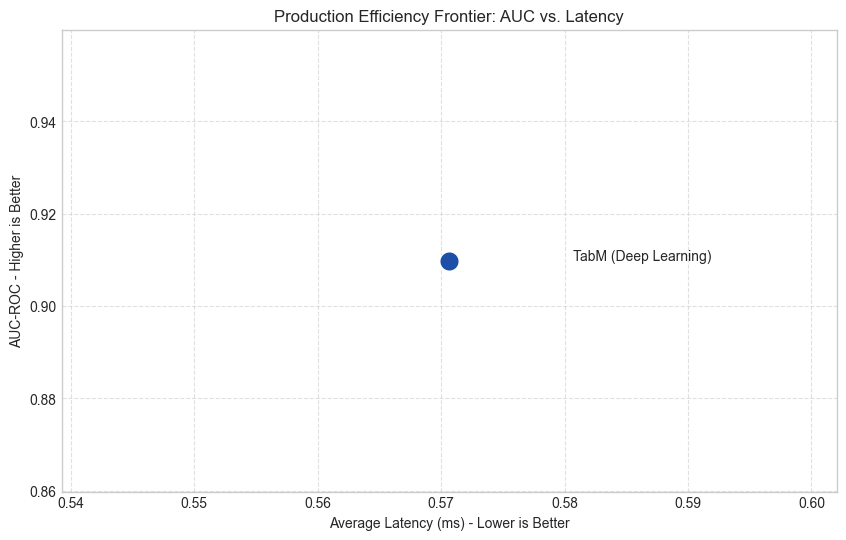

🏆 Efficiency Frontier generated!


In [7]:
try:
    with open(f"{REPORTS_PATH}/full_model_comparison.json", "r") as f:
        accuracy_data = json.load(f)
    
    df_acc = pd.DataFrame(accuracy_data).set_index('model')

    # Map TabM (Deep Learning) to the latency keys
    latency_map = {
        'Logistic Regression': 'Logistic Regression',
        'XGBoost': 'XGBoost',
        'Random Forest': 'Random Forest',
        'SVM': 'SVM',
        'TabM (Deep Learning)': 'TabM (ONNX)' # We use the optimized version for comparison
    }
    
    # Safely map latency
    def get_latency(model_name):
        mapped_name = latency_map.get(model_name)
        if mapped_name and mapped_name in df_latency.index:
            return df_latency.loc[mapped_name, 'mean']
        return None

    df_acc['latency_ms'] = df_acc.index.map(get_latency)

    # Plotting
    plt.figure(figsize=(10, 6))
    valid_plot_data = df_acc.dropna(subset=['latency_ms', 'auc_roc'])
    
    if not valid_plot_data.empty:
        sns.scatterplot(data=valid_plot_data, x='latency_ms', y='auc_roc', s=200, color=PRIMARY_COLOR)

        for i in range(valid_plot_data.shape[0]):
            row = valid_plot_data.iloc[i]
            plt.text(row.latency_ms + 0.01, row.auc_roc, row.name)

        plt.title('Production Efficiency Frontier: AUC vs. Latency')
        plt.xlabel('Average Latency (ms) - Lower is Better')
        plt.ylabel('AUC-ROC - Higher is Better')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        print("🏆 Efficiency Frontier generated!")
    else:
        print("⚠️ Not enough data to plot Efficiency Frontier.")

except FileNotFoundError:
    print("⚠️ Accuracy report not found. Cannot generate trade-off plot.")

## 6. Export Results
Saving the final combined report.

In [8]:
if 'df_acc' in locals():
    final_report = df_acc.reset_index().to_dict(orient='records')
    with open(f"{REPORTS_PATH}/production_leaderboard.json", "w") as f:
        json.dump(final_report, f, indent=4)
    print("✅ Production leaderboard saved to reports/metrics/production_leaderboard.json")

✅ Production leaderboard saved to reports/metrics/production_leaderboard.json
